In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [4]:
import time
import pandas as pd
import numpy as np
from keras.preprocessing import image
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import cv2

# Data set

In [3]:
train_df = pd.read_csv("SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing/train.txt", sep=" ", names=["image", "score"])
test_df = pd.read_csv("SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing/test.txt", sep=" ", names=["image", "score"])

In [5]:
train_df['purpose'] = 'train'
test_df['purpose'] = 'test'

In [6]:
np.random.seed(17)
val_set_size = int((40*train_df.shape[0])/100)
val_idx = np.random.choice(train_df.shape[0], size=val_set_size)

In [7]:
train_df.loc[val_idx, 'purpose'] = 'validation'

In [8]:
df = pd.concat([train_df, test_df])

In [9]:
del train_df, test_df

In [108]:
df.sample(5)[['image', 'score', 'purpose']]

,image,score,purpose
918,AM1976.jpg,3.250000,train
1459,AM1191.jpg,2.533333,train
261,AF1477.jpg,4.100000,train
999,AF1494.jpg,3.700000,validation
2129,AF1317.jpg,4.033333,test


In [115]:
df.iloc[[918, 1459, 261, 999, 2129]][['image', 'score', 'purpose']]

,image,score,purpose
918,AM1976.jpg,3.250000,train
1459,AM1191.jpg,2.533333,train
261,AF1477.jpg,4.100000,train
999,AF1494.jpg,3.700000,validation
2129,AM453.jpg,2.733333,train


In [11]:
df.shape

(5500, 3)

In [12]:
pd.DataFrame(df.purpose.value_counts()).rename(columns = {"purpose": "instances"})

,instances
train,2219
test,2200
validation,1081


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f91e48d4940>]],
      dtype=object)

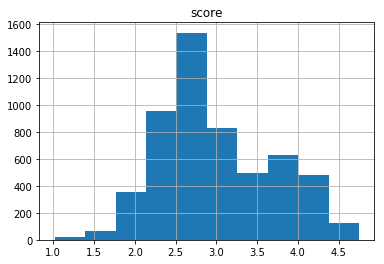

In [13]:
df.hist()

# Demography

In [14]:
def findRace(image_name):
    if image_name[0:1] == "C":
        return "Caucasian"
    else:
        return "Asian"

def findGender(image_name):
    if image_name[1:2] == "M":
        return "Male"
    else:
        return "Woman"

In [15]:
df["race"] = df["image"].progress_apply(findRace)
df["gender"] = df["image"].progress_apply(findGender)

100%|██████████| 5500/5500 [00:00<00:00, 588922.21it/s]


In [120]:
#df.sample(5)[['image', 'score', 'purpose', 'gender']]
df.sample(5)[['image', 'score', 'purpose', 'race', 'gender']]

,image,score,purpose,race,gender
43,AM1525.jpg,2.150000,validation,Asian,Male
1414,AM136.jpg,2.566667,validation,Asian,Male
287,AM809.jpg,2.316667,train,Asian,Male
565,CF30.jpg,3.366667,train,Caucasian,Woman
1210,CM258.jpg,3.183333,test,Caucasian,Male


In [17]:
pd.DataFrame(100*df.race.value_counts()/df.race.value_counts().sum()).rename(columns = {"race": "instance_percentage"})

,instance_percentage
Asian,72.727273
Caucasian,27.272727


In [18]:
pd.DataFrame(100*df.gender.value_counts()/df.gender.value_counts().sum()).rename(columns = {"gender": "instance_percentage"})

,instance_percentage
Woman,50.0
Male,50.0


# Image Pixels

In [19]:
def retrievePixels(img_name):
    path = "SCUT-FBP5500_v2/Images/%s" % (img_name)
    img = image.load_img(path, grayscale=False, target_size=(224, 224))
    x = image.img_to_array(img).reshape(1, -1)[0]
    return x

In [20]:
#df['pixels'] = df['image'].apply(retrievePixels)
df['pixels'] = df['image'].progress_apply(retrievePixels)

100%|██████████| 5500/5500 [00:16<00:00, 330.22it/s]


In [21]:
df.head()

,image,score,purpose,race,gender,pixels
0,CM148.jpg,3.516667,train,Caucasian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
1,AF1048.jpg,3.150000,validation,Asian,Woman,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,AM878.jpg,2.566667,train,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
3,AM1633.jpg,3.133333,train,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
4,AM1176.jpg,1.950000,validation,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."


In [22]:
features = []
pixels = df['pixels'].values
for i in range(0, pixels.shape[0]):
    features.append(pixels[i])

In [23]:
tic = time.time()

features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

toc = time.time()

print("converted to numpy in ",toc-tic,"seconds")

converted to numpy in  1.3266820907592773 seconds


# Modelling

In [25]:
import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

### Base VGG-Face Model

In [26]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [27]:
#pre-trained weights of vgg-face model. 
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
model.load_weights('vgg_face_weights.h5')

# Normalization

In [28]:
print("max score is ", df.score.max())
print("min score is ", df.score.min())

max score is  4.75
min score is  1.016667


In [29]:
#target normalization
max_limit = df.score.max()
min_limit = df.score.min()

#sigmoid removed in the final layer
#df.score = (df.score - min_limit) / (max_limit - min_limit)

# input normalization
features = features / 255

### Transfer Learning

In [30]:
num_of_classes = 1 #this is a regression problem

In [31]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Flatten()(model.layers[-4].output)
base_model_output = Dense(num_of_classes)(base_model_output)

#Mehmet Gonen recommended to remove sigmoid for a regression problem
#"You could but you should not"
#Should not I normalize output in this case?
#base_model_output = Activation('sigmoid')(base_model_output)

beauty_model = Model(inputs=model.input, outputs=base_model_output)

### Training

In [32]:
beauty_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())

In [33]:
checkpointer = ModelCheckpoint(
    filepath='beauty_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=50)

In [34]:
df.head()

,image,score,purpose,race,gender,pixels
0,CM148.jpg,3.516667,train,Caucasian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
1,AF1048.jpg,3.150000,validation,Asian,Woman,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,AM878.jpg,2.566667,train,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
3,AM1633.jpg,3.133333,train,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
4,AM1176.jpg,1.950000,validation,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."


In [35]:
train_idx = df[(df['purpose'] == 'train')].index
val_idx = df[(df['purpose'] == 'validation')].index
test_idx = df[(df['purpose'] == 'test')].index

In [36]:
score = beauty_model.fit(
    features[train_idx], df.iloc[train_idx].score
    , epochs=5000
    , validation_data=(features[val_idx], df.iloc[val_idx].score)
    , callbacks=[checkpointer, earlyStop]
)

Train on 2219 samples, validate on 1081 samples
Epoch 1/5000
2219/2219 [==============================] - 13s 6ms/step - loss: 0.6601 - val_loss: 0.3387

Epoch 00001: val_loss improved from inf to 0.33866, saving model to beauty_model.hdf5
Epoch 2/5000
2219/2219 [==============================] - 9s 4ms/step - loss: 0.3109 - val_loss: 0.3801

Epoch 00002: val_loss did not improve from 0.33866
Epoch 3/5000
2219/2219 [==============================] - 9s 4ms/step - loss: 0.2993 - val_loss: 0.2274

Epoch 00003: val_loss improved from 0.33866 to 0.22741, saving model to beauty_model.hdf5
Epoch 4/5000
2219/2219 [==============================] - 9s 4ms/step - loss: 0.2918 - val_loss: 0.2376

Epoch 00004: val_loss did not improve from 0.22741
Epoch 5/5000
2219/2219 [==============================] - 9s 4ms/step - loss: 0.2435 - val_loss: 0.1969

Epoch 00005: val_loss improved from 0.22741 to 0.19688, saving model to beauty_model.hdf5
Epoch 6/5000
2219/2219 [==============================] - 

2219/2219 [==============================] - 9s 4ms/step - loss: 0.1084 - val_loss: 0.1586

Epoch 00051: val_loss did not improve from 0.13377
Epoch 52/5000
2219/2219 [==============================] - 9s 4ms/step - loss: 0.1085 - val_loss: 0.1354

Epoch 00052: val_loss did not improve from 0.13377
Epoch 53/5000
2219/2219 [==============================] - 9s 4ms/step - loss: 0.1186 - val_loss: 0.1426

Epoch 00053: val_loss did not improve from 0.13377
Epoch 54/5000
2219/2219 [==============================] - 9s 4ms/step - loss: 0.1120 - val_loss: 0.2497

Epoch 00054: val_loss did not improve from 0.13377
Epoch 55/5000
2219/2219 [==============================] - 9s 4ms/step - loss: 0.1227 - val_loss: 0.1582

Epoch 00055: val_loss did not improve from 0.13377
Epoch 56/5000
2219/2219 [==============================] - 9s 4ms/step - loss: 0.1124 - val_loss: 0.1434

Epoch 00056: val_loss did not improve from 0.13377
Epoch 57/5000
2219/2219 [==============================] - 9s 4ms/step -

In [37]:
best_iteration = np.argmin(score.history['val_loss'])+1

val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]

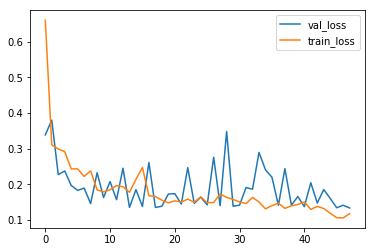

In [38]:
plt.plot(val_scores, label='val_loss')
plt.plot(train_scores, label='train_loss')
plt.legend(loc='upper right')
plt.show()

In [39]:
#restore the best weights
from keras.models import load_model
beauty_model = load_model("beauty_model.hdf5")
beauty_model.save_weights('beauty_model.h5')

## Performance

In [40]:
actuals = df.iloc[test_idx].score.values
predictions = beauty_model.predict(features[test_idx])

In [ ]:
#sigmoid removed in the final layer
#denormalize
#predictions = predictions * (max_limit - min_limit) + min_limit
#actuals = actuals * (max_limit - min_limit) + min_limit

In [125]:
perf = pd.DataFrame(actuals, columns = ["actuals"])
perf["predictions"] = predictions

In [130]:
print("pc: ",perf[['actuals', 'predictions']].corr(method ='pearson').values[0,1])
print("mae: ", mean_absolute_error(actuals, predictions))
print("rmse: ", sqrt(mean_squared_error(actuals, predictions)))

pc:  0.93629415207285
mae:  0.1759907865360815
rmse:  0.25044935574228544


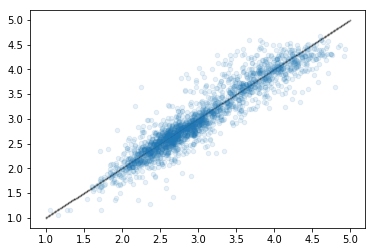

In [45]:
best_predictions = []
for i in np.arange(int(min_limit), int(max_limit) + 1, 0.01):
    best_predictions.append(round(i, 2))

plt.scatter(best_predictions, best_predictions, s=1, color = 'black', alpha=0.3)
plt.scatter(predictions, actuals, s=20, alpha=0.1)

## Prediction

In [46]:
def plotImage(df, idx):
    print("beauty score: ",df.iloc[idx].score)
    img = (df.iloc[idx]['pixels'].reshape([224, 224, 3])) / 255
    plt.imshow(img)
    plt.show()
    print("----------------")

In [47]:
def findPrediction(df, idx):
    img = df.iloc[idx].pixels / 255
    img = img.reshape(224, 224, 3)
    img = np.expand_dims(img, axis = 0)
    prediction = beauty_model.predict(img)[0, 0]
    return prediction

In [48]:
sample_set = df.sort_values(by=['score'], ascending=False).head(15)
sample_set = sample_set.reset_index(drop=True)

In [49]:
sample_set.head()

,image,score,purpose,race,gender,pixels
0,AF1973.jpg,4.750000,test,Asian,Woman,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
1,CF609.jpg,4.700000,test,Caucasian,Woman,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,AM22.jpg,4.700000,train,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
3,AM390.jpg,4.683333,test,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
4,AM1624.jpg,4.666667,train,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."


prediction:  4.5069084
beauty score:  4.7


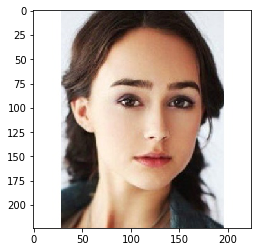

----------------
prediction:  4.9280825
beauty score:  4.65


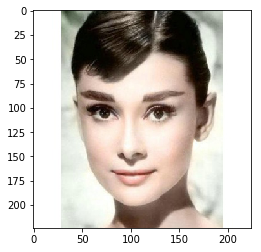

----------------
prediction:  4.5066147
beauty score:  4.65


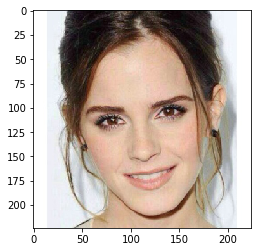

----------------
prediction:  4.438007
beauty score:  4.633333


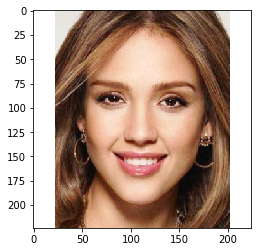

----------------
prediction:  4.616503
beauty score:  4.6


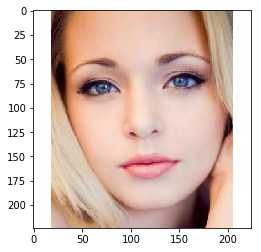

----------------


In [51]:
idx_list = sample_set.sort_values(by=['score'], ascending=False).index

index = 0
for idx in idx_list:
    if sample_set.iloc[idx].race != 'Asian':
        print("prediction: ",findPrediction(sample_set, idx))
        plotImage(sample_set, idx)
        index = index + 1
        
        if index == 5:
            break

## Custom Predictions

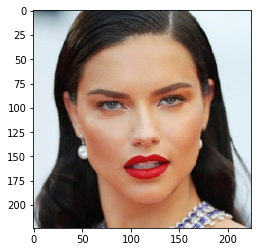

Prediction:  56.04760765284949
---------------------------


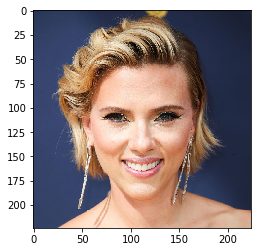

Prediction:  63.696361604152074
---------------------------


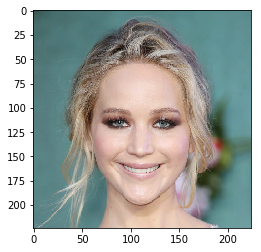

Prediction:  50.2562325205019
---------------------------


In [132]:
#demo_set = ['sefik-1.jpg', 'sefik-2.jpg', 'sefik-3.jpg']
demo_set = ['adriana.jpg', 'scarlet.jpg', 'jennifer.jpg']

for file in demo_set:
    path = 'test/%s' % (file) 
    img = image.load_img(path, grayscale=False, target_size=(224, 224, 3))
    img = image.img_to_array(img).reshape(1, -1)[0]
    img = img.reshape(224, 224, 3)
    img = img / 255
    
    plt.imshow(img)
    plt.show()
    
    #-----------------------
    
    img = np.expand_dims(img, axis=0)

    prediction = beauty_model.predict(img)[0, 0]
    prediction = 100*(prediction - min_limit) / (max_limit - min_limit)

    print("Prediction: ", prediction)
    print("---------------------------")

# IMDB Data Set

In [56]:
import scipy.io
mat = scipy.io.loadmat('../imdb_crop/imdb.mat')

In [57]:
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score", "celeb_names", "celeb_id"]

In [58]:
instances = mat['imdb'][0][0][0].shape[1]

In [59]:
imdb_df = pd.DataFrame(index = range(0,instances), columns = columns)

In [60]:
imdb_df.shape

(460723, 10)

In [61]:
for i in mat:
    if i == "imdb":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            #print(j,". ",columns[j],": ",current_array[j][0])
            imdb_df[columns[j]] = pd.DataFrame(current_array[j][0])

In [62]:
imdb_df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id
0,693726,1968,[01/nm0000001_rm124825600_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.459693,1.118973,['Lee' George Quinones],6488
1,693726,1970,[01/nm0000001_rm3343756032_1899-5-10_1970.jpg],1.0,[Fred Astaire],"[[477.184, 100.352, 622.592, 245.76]]",2.543198,1.852008,['Weird Al' Yankovic],6488
2,693726,1968,[01/nm0000001_rm577153792_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[114.96964308962852, 114.96964308962852, 451....",3.455579,2.985660,[2 Chainz],6488
3,693726,1968,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,[50 Cent],6488
4,693726,1968,[01/nm0000001_rm980463616_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1013.8590023603723, 233.8820422075853, 1201....",1.158766,NaN,[A Martinez],6488


In [63]:
#remove pictures does not include face
imdb_df = imdb_df[imdb_df['face_score'] != -np.inf]

#some pictures include more than one face, remove them
imdb_df = imdb_df[imdb_df['second_face_score'].isna()]

#check threshold
imdb_df = imdb_df[imdb_df['face_score'] >= 3]

In [64]:
imdb_df.shape

(95234, 10)

In [65]:
def extractNames(name):
    return name[0]

imdb_df['celebrity_name'] = imdb_df['name'].apply(extractNames)

In [68]:
def getImagePixels(image_path):
    img = image.load_img("../imdb_crop/%s" % image_path[0], grayscale=False, target_size=(224, 224, 3))
    x = image.img_to_array(img).reshape(1, -1)[0]
    #x = preprocess_input(x)
    return x

In [69]:
imdb_df['pixels'] = imdb_df['full_path'].apply(getImagePixels)
#imdb_df['pixels'] = imdb_df['full_path'].progress_apply(getImagePixels)

In [70]:
imdb_features = []
pixels = imdb_df['pixels'].values
for i in range(0, pixels.shape[0]):
    imdb_features.append(pixels[i])

In [71]:
imdb_features = np.array(imdb_features)
imdb_features = imdb_features.reshape(imdb_features.shape[0], 224, 224, 3)

In [72]:
imdb_features = imdb_features / 255

In [73]:
imdb_df['beauty'] = beauty_model.predict(imdb_features)

In [74]:
imdb_df = imdb_df.sort_values(by=['beauty'], ascending=False)
imdb_df = imdb_df.reset_index(drop=True)

In [75]:
imdb_df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,celebrity_name,pixels,beauty
0,717546,2014,[53/nm0521753_rm3041640448_1964-7-28_2014.jpg],0.0,[Lori Loughlin],"[[604.4803501539405, 326.434650082891, 1019.50...",6.145393,NaN,NaN,12086,Lori Loughlin,"[239.0, 242.0, 247.0, 239.0, 242.0, 247.0, 239...",5.375183
1,725372,2012,[89/nm4577989_rm2777658624_1986-0-0_2012.jpg],0.0,[Tea Falco],"[[960.2199148568404, 374.67041133321567, 1437....",5.428181,NaN,NaN,18673,Tea Falco,"[161.0, 172.0, 158.0, 163.0, 174.0, 158.0, 163...",5.310462
2,726705,2013,[38/nm2294338_rm1309537536_1989-8-25_2013.jpg],1.0,[Keegan Joyce],"[[841.0363740443591, 422.2896870221796, 1465.6...",5.964730,NaN,NaN,10733,Keegan Joyce,"[252.0, 253.0, 235.0, 252.0, 253.0, 237.0, 252...",5.249801
3,724754,2007,[40/nm0752740_rm3334314240_1984-4-22_2007.jpg],0.0,[Michelle Ryan],"[[138.96, 127.44, 241.92000000000002, 230.4]]",3.782545,NaN,NaN,13829,Michelle Ryan,"[182.0, 171.0, 177.0, 182.0, 171.0, 177.0, 183...",5.197234
4,722954,2015,[02/nm2966102_rm858255872_1979-5-19_2015.jpg],0.0,[Bérénice Marlohe],"[[280.09370007104945, 465.45750011841574, 1112...",5.861534,NaN,NaN,2774,Bérénice Marlohe,"[219.0, 213.0, 213.0, 219.0, 213.0, 213.0, 219...",5.187190


Lori Loughlin  ( Woman )
Beauty score:  116.75


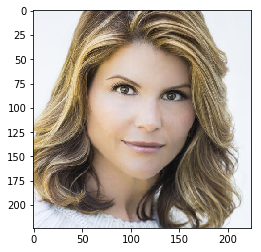

-----------------
Tea Falco  ( Woman )
Beauty score:  115.01


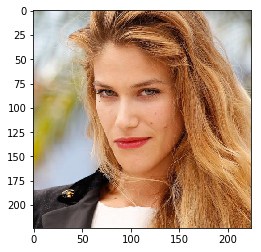

-----------------
Michelle Ryan  ( Woman )
Beauty score:  111.98


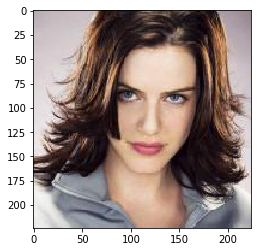

-----------------
Bérénice Marlohe  ( Woman )
Beauty score:  111.71


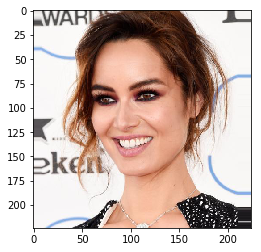

-----------------
Chyler Leigh  ( Woman )
Beauty score:  108.43


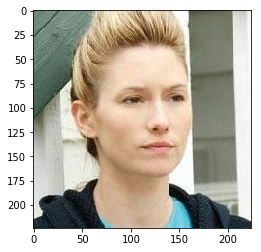

-----------------
Greta Gerwig  ( Woman )
Beauty score:  106.81


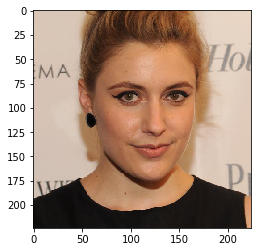

-----------------
Jena Malone  ( Woman )
Beauty score:  106.39


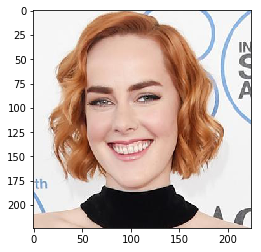

-----------------
January Jones  ( Woman )
Beauty score:  105.07


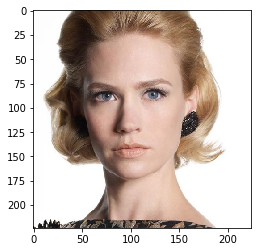

-----------------
Skyler Samuels  ( Woman )
Beauty score:  104.81


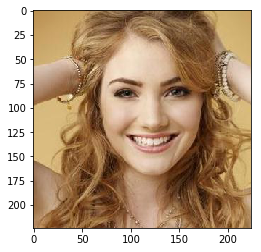

-----------------
Jena Malone  ( Woman )
Beauty score:  104.04


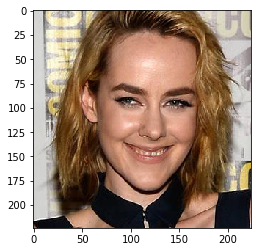

-----------------


In [141]:
#for index, instance in imdb_df.head(15).iterrows():
for index, instance in imdb_df[imdb_df.gender == 0].head(10).iterrows():
#for index, instance in imdb_df[imdb_df.index >= 30].head(10).iterrows():
    
    if instance.gender == 0:
        gender = "Woman"
    else:
        gender = "Man"
    
    print(instance["name"][0]," (",gender,")")
    
    beauty_score = instance.beauty
    beauty_score = 100 * (beauty_score - min_limit) / (max_limit - min_limit)
    beauty_score = round(beauty_score, 2)
    """if beauty_score > 100:
        beauty_score = 100"""
    
    print("Beauty score: ", beauty_score)
    img = instance["pixels"]
    img = img.reshape(224, 224, 3)
    
    img = img / 255
    
    #bgr to rgb
    #img = img[...,::-1]
    
    plt.imshow(img)
    plt.show()
    
    print("-----------------")